# Türkiye'ye Benzer Ülkeleri Bulma Analizi
Bu notebook, simple_data klasöründeki verileri kullanarak future_predictions_2025_2030.csv dosyasındaki ülkelerden hangilerinin Türkiye'ye benzer olduğunu bulur.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Veri yükleme
e_coli = pd.read_csv('simple_data/e_coli_ARM.csv')
s_aureus = pd.read_csv('simple_data/s_aureus_ARM.csv')
antibiotic_consumption = pd.read_csv('simple_data/antibiotic-consumption-rate.csv')
future_predictions = pd.read_csv('final_model/future_predictions_2025_2030.csv')

print("Veri setleri yüklendi.")
print(f"E. coli veri boyutu: {e_coli.shape}")
print(f"S. aureus veri boyutu: {s_aureus.shape}")
print(f"Antibiyotik tüketimi veri boyutu: {antibiotic_consumption.shape}")
print(f"Gelecek tahminleri veri boyutu: {future_predictions.shape}")

Veri setleri yüklendi.
E. coli veri boyutu: (414, 4)
S. aureus veri boyutu: (393, 4)
Antibiyotik tüketimi veri boyutu: (340, 4)
Gelecek tahminleri veri boyutu: (876, 4)


In [2]:
# Future predictions'daki benzersiz ülkeler
prediction_countries = future_predictions['Country'].unique()
print(f"Tahmin dosyasındaki ülke sayısı: {len(prediction_countries)}")
print(f"Ülkeler: {sorted(prediction_countries)}")

Tahmin dosyasındaki ülke sayısı: 30
Ülkeler: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']


In [3]:
# Türkiye verilerini kontrol et
turkey_ecoli = e_coli[e_coli['Entity'] == 'Turkey']
turkey_saureus = s_aureus[s_aureus['Entity'] == 'Turkey']

print("Türkiye E. coli verileri:")
print(turkey_ecoli)
print("\nTürkiye S. aureus verileri:")
print(turkey_saureus)

Türkiye E. coli verileri:
     Entity Code  Year  e_coli_ARM_percent
385  Turkey  TUR  2021               53.77

Türkiye S. aureus verileri:
     Entity Code  Year  s_aureus_ARM_percent
369  Turkey  TUR  2021                 30.99


In [4]:
# En son yıl verilerini al (her ülke için)
ecoli_latest = e_coli.sort_values('Year').groupby('Entity').last().reset_index()
saureus_latest = s_aureus.sort_values('Year').groupby('Entity').last().reset_index()
consumption_latest = antibiotic_consumption.sort_values('Year').groupby('Entity').last().reset_index()

print("En son yıl verileri alındı.")
print(f"E. coli: {len(ecoli_latest)} ülke")
print(f"S. aureus: {len(saureus_latest)} ülke")
print(f"Antibiyotik tüketimi: {len(consumption_latest)} ülke")

En son yıl verileri alındı.
E. coli: 110 ülke
S. aureus: 107 ülke
Antibiyotik tüketimi: 67 ülke


In [5]:
# Verileri birleştir
merged_data = ecoli_latest[['Entity', 'e_coli_ARM_percent']].merge(
    saureus_latest[['Entity', 's_aureus_ARM_percent']], 
    on='Entity', 
    how='outer'
)

merged_data = merged_data.merge(
    consumption_latest[['Entity', 'am_consumption_rate']], 
    on='Entity', 
    how='outer'
)

# Future predictions'dan ortalama direnç oranlarını ekle
future_avg = future_predictions[future_predictions['Year'] == 2025].groupby('Country')['Predicted_Resistance_%'].mean().reset_index()
future_avg.columns = ['Entity', 'avg_predicted_resistance_2025']

merged_data = merged_data.merge(
    future_avg, 
    on='Entity', 
    how='outer'
)

print(f"Birleştirilmiş veri boyutu: {merged_data.shape}")
print(f"\nİlk 5 satır:")
print(merged_data.head())

Birleştirilmiş veri boyutu: (131, 5)

İlk 5 satır:
        Entity  e_coli_ARM_percent  s_aureus_ARM_percent  am_consumption_rate  \
0  Afghanistan               80.77                   NaN                  NaN   
1  Africa (UN)               70.00                 44.12                  NaN   
2      Albania               31.25                   NaN                  NaN   
3    Argentina               19.76                 34.33                  NaN   
4    Asia (UN)               51.67                 37.70                  NaN   

   avg_predicted_resistance_2025  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN  


In [6]:
# Sadece prediction countries'deki ülkeleri ve Türkiye'yi filtrele
countries_to_analyze = list(prediction_countries) + ['Turkey']
filtered_data = merged_data[merged_data['Entity'].isin(countries_to_analyze)].copy()

print(f"Analiz edilecek ülke sayısı: {len(filtered_data)}")
print(f"\nEksik veri durumu:")
print(filtered_data.isnull().sum())

Analiz edilecek ülke sayısı: 31

Eksik veri durumu:
Entity                           0
e_coli_ARM_percent               8
s_aureus_ARM_percent             8
am_consumption_rate              6
avg_predicted_resistance_2025    1
dtype: int64


In [7]:
# Eksik verileri doldur (ortanca ile)
for col in ['e_coli_ARM_percent', 's_aureus_ARM_percent', 'am_consumption_rate', 'avg_predicted_resistance_2025']:
    if col in filtered_data.columns:
        median_val = filtered_data[col].median()
        filtered_data[col].fillna(median_val, inplace=True)

print("Eksik veriler dolduruldu.")
print(f"\nGüncellenmiş eksik veri durumu:")
print(filtered_data.isnull().sum())

Eksik veriler dolduruldu.

Güncellenmiş eksik veri durumu:
Entity                           0
e_coli_ARM_percent               0
s_aureus_ARM_percent             0
am_consumption_rate              0
avg_predicted_resistance_2025    0
dtype: int64


In [8]:
# Türkiye'nin verilerini kontrol et
turkey_data = filtered_data[filtered_data['Entity'] == 'Turkey']
print("Türkiye'nin özellikleri:")
print(turkey_data)

Türkiye'nin özellikleri:
     Entity  e_coli_ARM_percent  s_aureus_ARM_percent  am_consumption_rate  \
102  Turkey               53.77                 30.99            18.545908   

     avg_predicted_resistance_2025  
102                          6.068  


In [9]:
# Özellik matrisini oluştur
feature_columns = ['e_coli_ARM_percent', 's_aureus_ARM_percent', 'am_consumption_rate', 'avg_predicted_resistance_2025']
X = filtered_data[feature_columns].values

# Verileri standartlaştır
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Özellik matrisi boyutu: {X_scaled.shape}")

Özellik matrisi boyutu: (31, 4)


In [10]:
# Türkiye'nin indeksini bul
turkey_idx = filtered_data[filtered_data['Entity'] == 'Turkey'].index[0]
turkey_idx_in_array = filtered_data.index.get_loc(turkey_idx)

print(f"Türkiye'nin indeksi: {turkey_idx_in_array}")

Türkiye'nin indeksi: 21


In [11]:
# Kosinüs benzerliği hesapla
similarities = cosine_similarity([X_scaled[turkey_idx_in_array]], X_scaled)[0]

# Benzerlik skorlarını DataFrame'e ekle
filtered_data['similarity_to_turkey'] = similarities

# Türkiye hariç, en benzer 10 ülkeyi göster
similar_countries = filtered_data[filtered_data['Entity'] != 'Turkey'].sort_values(
    'similarity_to_turkey', 
    ascending=False
).head(10)

print("\nTÜRKİYE'YE EN BENZER 10 ÜLKE:")
print("="*80)
for idx, row in similar_countries.iterrows():
    print(f"{row['Entity']:20} - Benzerlik Skoru: {row['similarity_to_turkey']:.4f}")
    print(f"  E. coli ARM: {row['e_coli_ARM_percent']:.2f}%")
    print(f"  S. aureus ARM: {row['s_aureus_ARM_percent']:.2f}%")
    print(f"  Antibiyotik tüketimi: {row['am_consumption_rate']:.2f}")
    print(f"  2025 Ortalama tahmin: {row['avg_predicted_resistance_2025']:.2f}%")
    print()


TÜRKİYE'YE EN BENZER 10 ÜLKE:
Cyprus               - Benzerlik Skoru: 0.6281
  E. coli ARM: 41.03%
  S. aureus ARM: 42.94%
  Antibiyotik tüketimi: 34.14
  2025 Ortalama tahmin: 37.68%

Italy                - Benzerlik Skoru: 0.6084
  E. coli ARM: 24.60%
  S. aureus ARM: 30.88%
  Antibiyotik tüketimi: 24.37
  2025 Ortalama tahmin: 26.25%

Croatia              - Benzerlik Skoru: 0.3283
  E. coli ARM: 18.18%
  S. aureus ARM: 66.67%
  Antibiyotik tüketimi: 19.90
  2025 Ortalama tahmin: 35.39%

Greece               - Benzerlik Skoru: 0.3209
  E. coli ARM: 21.93%
  S. aureus ARM: 43.18%
  Antibiyotik tüketimi: 18.55
  2025 Ortalama tahmin: 49.89%

Poland               - Benzerlik Skoru: 0.2380
  E. coli ARM: 18.83%
  S. aureus ARM: 16.52%
  Antibiyotik tüketimi: 24.45
  2025 Ortalama tahmin: 31.33%

Latvia               - Benzerlik Skoru: 0.2009
  E. coli ARM: 18.91%
  S. aureus ARM: 4.55%
  Antibiyotik tüketimi: 15.60
  2025 Ortalama tahmin: 24.92%

Malta                - Benzerlik Skoru: 

In [12]:
# Türkiye'nin değerlerini göster
print("\nTÜRKİYE'NİN DEĞERLERİ:")
print("="*80)
turkey_row = filtered_data[filtered_data['Entity'] == 'Turkey'].iloc[0]
print(f"E. coli ARM: {turkey_row['e_coli_ARM_percent']:.2f}%")
print(f"S. aureus ARM: {turkey_row['s_aureus_ARM_percent']:.2f}%")
print(f"Antibiyotik tüketimi: {turkey_row['am_consumption_rate']:.2f}")
print(f"2025 Ortalama tahmin: {turkey_row['avg_predicted_resistance_2025']:.2f}%")


TÜRKİYE'NİN DEĞERLERİ:
E. coli ARM: 53.77%
S. aureus ARM: 30.99%
Antibiyotik tüketimi: 18.55
2025 Ortalama tahmin: 6.07%


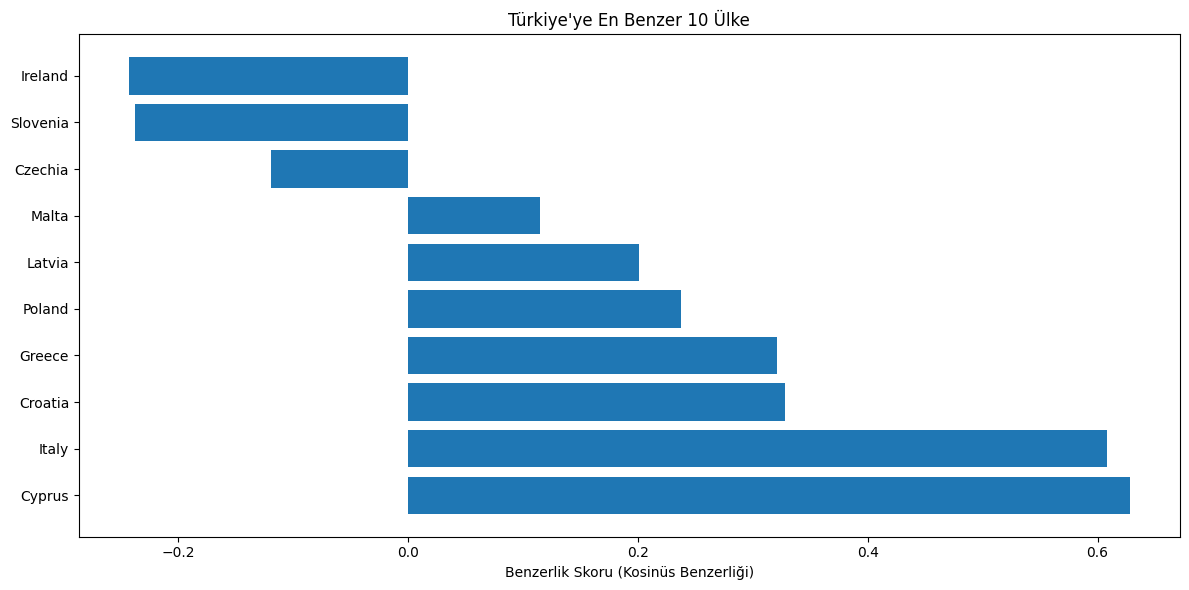

In [13]:
# Görselleştirme - En benzer 10 ülke
plt.figure(figsize=(12, 6))
top_10 = filtered_data[filtered_data['Entity'] != 'Turkey'].nlargest(10, 'similarity_to_turkey')
plt.barh(top_10['Entity'], top_10['similarity_to_turkey'])
plt.xlabel('Benzerlik Skoru (Kosinüs Benzerliği)')
plt.title('Türkiye\'ye En Benzer 10 Ülke')
plt.tight_layout()
plt.show()

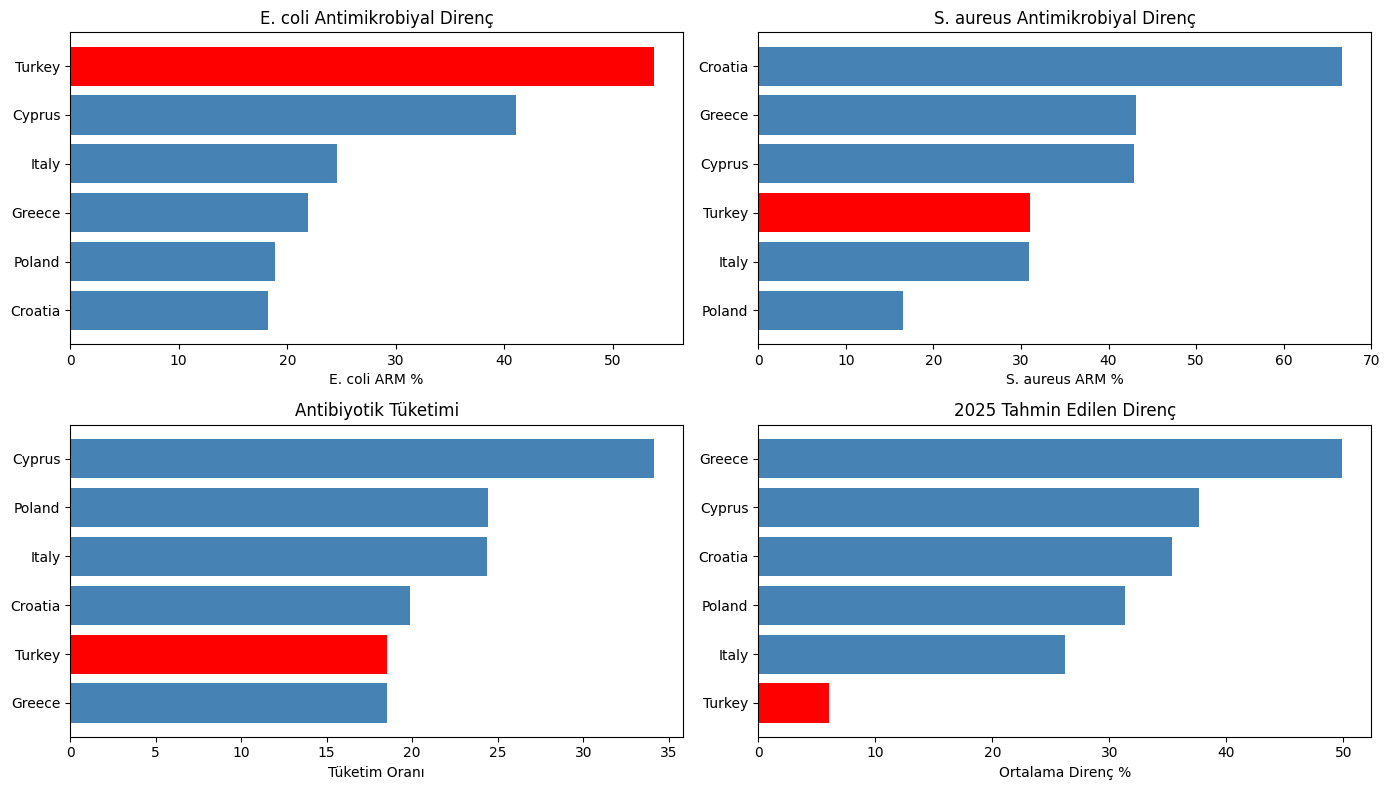

In [14]:
# Karşılaştırma tablosu - Türkiye ve en benzer 5 ülke
top_5_countries = similar_countries.head(5)['Entity'].tolist()
comparison_data = filtered_data[filtered_data['Entity'].isin(['Turkey'] + top_5_countries)]

plt.figure(figsize=(14, 8))

# E. coli ARM
plt.subplot(2, 2, 1)
comparison_data_sorted = comparison_data.sort_values('e_coli_ARM_percent')
colors = ['red' if x == 'Turkey' else 'steelblue' for x in comparison_data_sorted['Entity']]
plt.barh(comparison_data_sorted['Entity'], comparison_data_sorted['e_coli_ARM_percent'], color=colors)
plt.xlabel('E. coli ARM %')
plt.title('E. coli Antimikrobiyal Direnç')

# S. aureus ARM
plt.subplot(2, 2, 2)
comparison_data_sorted = comparison_data.sort_values('s_aureus_ARM_percent')
colors = ['red' if x == 'Turkey' else 'steelblue' for x in comparison_data_sorted['Entity']]
plt.barh(comparison_data_sorted['Entity'], comparison_data_sorted['s_aureus_ARM_percent'], color=colors)
plt.xlabel('S. aureus ARM %')
plt.title('S. aureus Antimikrobiyal Direnç')

# Antibiyotik Tüketimi
plt.subplot(2, 2, 3)
comparison_data_sorted = comparison_data.sort_values('am_consumption_rate')
colors = ['red' if x == 'Turkey' else 'steelblue' for x in comparison_data_sorted['Entity']]
plt.barh(comparison_data_sorted['Entity'], comparison_data_sorted['am_consumption_rate'], color=colors)
plt.xlabel('Tüketim Oranı')
plt.title('Antibiyotik Tüketimi')

# 2025 Tahmin
plt.subplot(2, 2, 4)
comparison_data_sorted = comparison_data.sort_values('avg_predicted_resistance_2025')
colors = ['red' if x == 'Turkey' else 'steelblue' for x in comparison_data_sorted['Entity']]
plt.barh(comparison_data_sorted['Entity'], comparison_data_sorted['avg_predicted_resistance_2025'], color=colors)
plt.xlabel('Ortalama Direnç %')
plt.title('2025 Tahmin Edilen Direnç')

plt.tight_layout()
plt.show()

In [15]:
# Sonuçları kaydet
result_df = filtered_data[filtered_data['Entity'] != 'Turkey'].sort_values(
    'similarity_to_turkey', 
    ascending=False
)[['Entity', 'similarity_to_turkey', 'e_coli_ARM_percent', 's_aureus_ARM_percent', 
   'am_consumption_rate', 'avg_predicted_resistance_2025']]

result_df.to_csv('turkey_similar_countries.csv', index=False)
print("\nSonuçlar 'turkey_similar_countries.csv' dosyasına kaydedildi.")
print(f"\nToplam {len(result_df)} ülke analiz edildi.")


Sonuçlar 'turkey_similar_countries.csv' dosyasına kaydedildi.

Toplam 30 ülke analiz edildi.


In [16]:
# Özet istatistikler
print("\nÖZET İSTATİSTİKLER:")
print("="*80)
print(f"En yüksek benzerlik skoru: {result_df['similarity_to_turkey'].max():.4f}")
print(f"En düşük benzerlik skoru: {result_df['similarity_to_turkey'].min():.4f}")
print(f"Ortalama benzerlik skoru: {result_df['similarity_to_turkey'].mean():.4f}")
print(f"\nBenzerlik skoru >= 0.95 olan ülke sayısı: {len(result_df[result_df['similarity_to_turkey'] >= 0.95])}")
print(f"Benzerlik skoru >= 0.90 olan ülke sayısı: {len(result_df[result_df['similarity_to_turkey'] >= 0.90])}")


ÖZET İSTATİSTİKLER:
En yüksek benzerlik skoru: 0.6281
En düşük benzerlik skoru: -0.6940
Ortalama benzerlik skoru: -0.2107

Benzerlik skoru >= 0.95 olan ülke sayısı: 0
Benzerlik skoru >= 0.90 olan ülke sayısı: 0
